**ME700 HW3 Part B**    
implement a large deformation example and demonstrate both h and p mesh refinement studies.


I decieded to use the example in part A, but apply bigger forces to achieve large displacements.

**Impprting Modules**

In [1]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import discretization as di
import numpy as np
import matplotlib.pyplot as plt

**Functions**

In [2]:
# definning a fucntion for getting the number of DoF for a mesh
def calc_mesh_dof( ele_type, coords):
    _, ndof, _ = di.element_info(ele_type)
    n_nodes = coords.shape[0]
    mesh_ndof = ndof * n_nodes
    return mesh_ndof

def find_tip_displacement( L_x, L_y, coords, dispfield, tol = 1e-8 ):
    # Find the node at the tip center (x = L_x, y = L_y / 2)
    ii = np.where(
        (np.abs(coords[:, 0] - L_x) < tol) & 
        (np.abs(coords[:, 1] - L_y / 2) < tol)
    )
    tipdisp = dispfield[ii, 1].item()
    return tipdisp

def solve_hyperelastic_rect_mesh(ele_type, L_x, L_y, N_x, N_y, q, nr_num_steps, material_properties_dict):
    """Solves a 2D hyperelastic problem on a rectangular mesh."""

    #--- Get Element Info ---
    _, ndof, _ = di.element_info(ele_type)

    #--- Generate Mesh ---
    origin_x, origin_y = 0.0, 0.0
    coords, connect = pre.generate_rect_mesh_2d(
        ele_type,
        origin_x, origin_y,
        origin_x + L_x, origin_y + L_y,
        N_x, N_y
    )

    #--- Define Boundaries ---
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
        coords, connect, ele_type,
        origin_x, origin_x + L_x,
        origin_y, origin_y + L_y
    )

    # Fixed boundary on the left edge: u_x = u_y = 0
    fixed_nodes = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

    # Apply uniform load on the top edge in x-direction
    dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)

    #--- Material Properties ---
    mu = material_properties_dict['mu']
    kappa = material_properties_dict['kappa']

    material_props = np.array([mu, kappa])

    #--- Solve Nonlinear Problem ---
    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,
        connect.T,
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-9,
        nr_maxit=30
    )

    return coords, connect, displacements_all, nr_info_all

def solver_for_several_meshes(ele_type, L_x, L_y, mesh_size_lst, q, nr_num_steps, material_properties_dict, tol = 1e-8):
    meshsize2result_dict = {"ele_type": ele_type}
    for mesh_size in mesh_size_lst:
        N_x, N_y = mesh_size
        print( f"\n Operations for mesh Nx: {N_x}, Ny {N_y}")
        coords, _, displacements_all, _ = solve_hyperelastic_rect_mesh(ele_type, L_x, L_y, N_x, N_y, q, nr_num_steps, material_properties_dict)
        mesh_ndof = calc_mesh_dof(ele_type, coords)
        dispfield = displacements_all[0].reshape( -1, 2)
        tipdisp = find_tip_displacement( L_x, L_y, coords, dispfield, tol = tol )
        
        meshsize2result_dict[(N_x, N_y)] = [coords, dispfield, tipdisp, mesh_ndof]
    return meshsize2result_dict

**Parameters**

In [3]:
#--- Material Properties ---
nu = 0.3
E = 100000

mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_properties_dict = {'nu': nu, 'E': E, 'mu': mu, 'kappa': kappa}

#--- Geometry Parameters ---
ratio = 25
L_y = 1                          # Width
L_x = ratio * L_y               # Length


**Solving the problem: D2_nn8_quad**

In [4]:
#--- Mesh Sizes: (N_x, N_y) ---
ele_type = 'D2_nn8_quad'        # Type of element for the mesh
mesh_size_lst = [(50, 2), (100, 4), (150, 6), (200, 8), (250, 10), (350, 14)]

#--- Solver Setup ---
q = -1                       # Applied traction in x-direction
nr_num_steps = 1               # Number of Newton-Raphson steps

meshsize2result_D2nn8quad_dict = solver_for_several_meshes(ele_type, L_x, L_y, mesh_size_lst, q, nr_num_steps, material_properties_dict)


 Operations for mesh Nx: 50, Ny 2
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=3.248488e-03, tolerance=1.000000e-09
Iteration 2, Correction=1.100788e-01, Residual=2.704845e+01, tolerance=1.000000e-09
Iteration 3, Correction=4.418091e-03, Residual=9.595196e-01, tolerance=1.000000e-09
Iteration 4, Correction=7.867951e-03, Residual=1.557151e-03, tolerance=1.000000e-09
Iteration 5, Correction=1.785886e-04, Residual=3.107976e-03, tolerance=1.000000e-09
Iteration 6, Correction=7.679890e-06, Residual=1.285023e-06, tolerance=1.000000e-09
Iteration 7, Correction=1.367894e-10, Residual=2.341636e-09, tolerance=1.000000e-09

 Operations for mesh Nx: 100, Ny 4
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=6.607494e-04, tolerance=1.000000e-09
Iteration 2, Correction=1.100649e-01, Residual=5.511175e+00, tolerance=1.000000e-09
Iteration 3, Correction=4.428701e-03, Residual=1.959069e-01, tolerance=1.000000e-09
Iteration 4, Correction=7.853841e

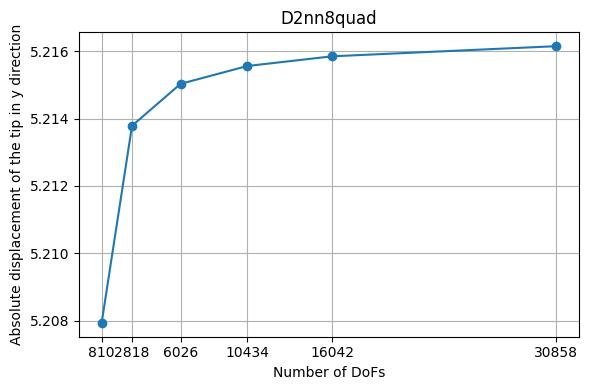

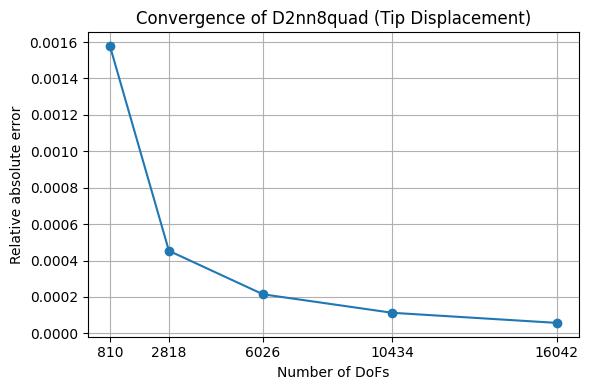

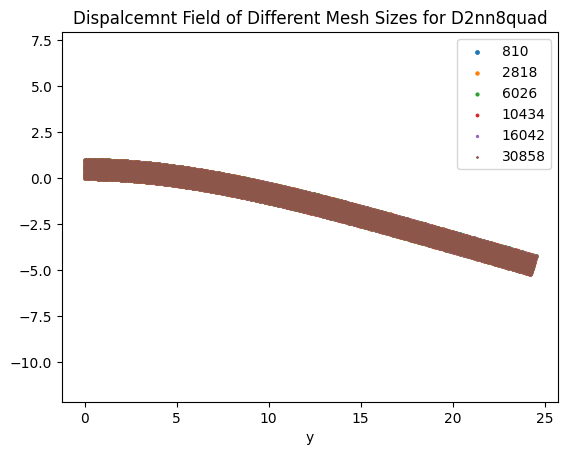

In [ ]:
%matplotlib inline
tipcenterdisp_D2nn8quad_lst = []
ndof_D2nn8quad_lst = []

tol = 1e-8  # Numerical tolerance for locating the tip node

for mesh_size in mesh_size_lst:
    coords, dispfield, tipdisp, mesh_ndof = meshsize2result_D2nn8quad_dict[ mesh_size ]
    # Append the absolute y-displacement at the tip
    tipcenterdisp_D2nn8quad_lst.append(np.abs( tipdisp ))
    ndof_D2nn8quad_lst.append( mesh_ndof )

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn8quad_lst,
    tipcenterdisp_D2nn8quad_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn8quad_lst)
plt.xlabel("Number of DoFs")
plt.ylabel("Absolute displacement of the tip in y direction")
plt.title("D2nn8quad")
plt.grid(True)
plt.tight_layout()


# Reference value from the finest mesh
ref_val = tipcenterdisp_D2nn8quad_lst[-1]

# Compute relative absolute error for each mesh
rel_error_D2nn8quad_lst = [
    np.abs( val - ref_val ) / np.abs(ref_val)
    for val in tipcenterdisp_D2nn8quad_lst[:-1]
]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn8quad_lst[:-1],
    rel_error_D2nn8quad_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn8quad_lst[:-1])
plt.xlabel("Number of DoFs")
plt.ylabel("Absolute relative error")
plt.title("Convergence of D2nn8quad (Tip Displacement)")
plt.grid(True)
plt.tight_layout()


plt.figure()
for i, mesh_size in enumerate( mesh_size_lst ):
    coords, dispfield, tipdisp, mesh_ndof = meshsize2result_D2nn8quad_dict[ mesh_size ]
    init_conf = coords.copy()
    final_conf = init_conf + dispfield
    
    plt.scatter( final_conf[:, 0], final_conf[:, 1], s = len( mesh_size_lst ) - i )
plt.axis('equal')
plt.legend(["Nx, Ny: (50, 2)", "(100, 4)", "(150, 6)", "(200, 8)", "(250, 10)", "(350, 14)"])
plt.title('Dispalcemnt Field of Different Mesh Sizes for D2nn8quad')
plt.xlabel('x')
plt.xlabel('y')

plt.show()


**Solving the problem: D2_nn4_quad**

In [13]:
#--- Mesh Sizes: (N_x, N_y) ---
ele_type = 'D2_nn4_quad'        # Type of element for the mesh
mesh_size_lst = [(50, 2), (100, 4), (150, 6), (200, 8), (250, 10), (350, 14)]

#--- Solver Setup ---
q = -1                       # Applied traction in x-direction
nr_num_steps = 1               # Number of Newton-Raphson steps

meshsize2result_D2nn4quad_dict = solver_for_several_meshes(ele_type, L_x, L_y, mesh_size_lst, q, nr_num_steps, material_properties_dict)


 Operations for mesh Nx: 50, Ny 2
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=1.146705e-02, tolerance=1.000000e-09
Iteration 2, Correction=9.692431e-02, Residual=7.244612e+01, tolerance=1.000000e-09
Iteration 3, Correction=2.943767e-03, Residual=2.000553e+00, tolerance=1.000000e-09
Iteration 4, Correction=7.136113e-03, Residual=2.171505e-03, tolerance=1.000000e-09
Iteration 5, Correction=5.169432e-05, Residual=6.030056e-03, tolerance=1.000000e-09
Iteration 6, Correction=1.092845e-06, Residual=3.121838e-07, tolerance=1.000000e-09
Iteration 7, Correction=1.127983e-12, Residual=1.259180e-10, tolerance=1.000000e-09

 Operations for mesh Nx: 100, Ny 4
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=2.465948e-03, tolerance=1.000000e-09
Iteration 2, Correction=1.064433e-01, Residual=1.909623e+01, tolerance=1.000000e-09
Iteration 3, Correction=4.003886e-03, Residual=6.353071e-01, tolerance=1.000000e-09
Iteration 4, Correction=7.725017e

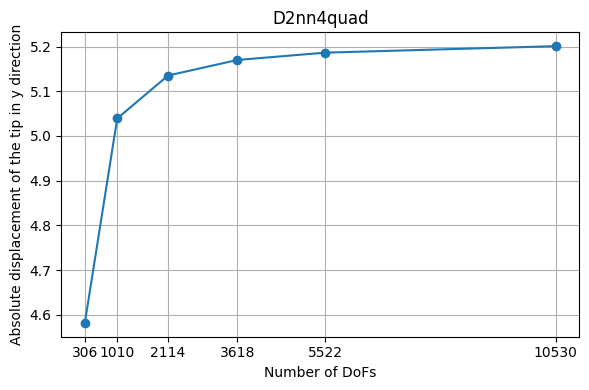

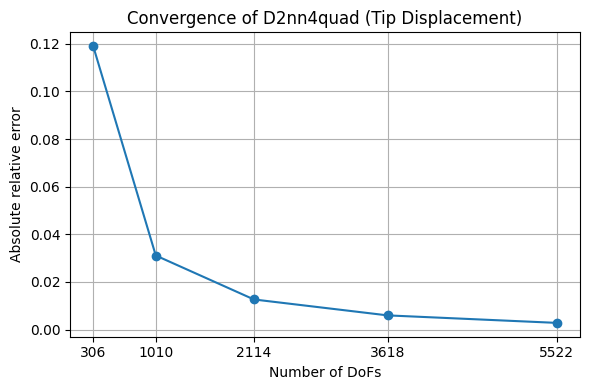

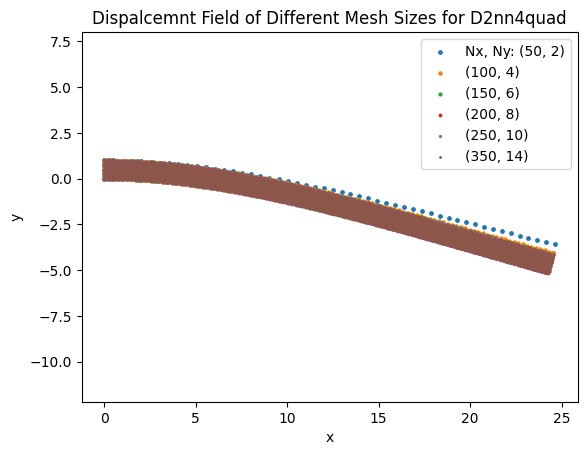

In [ ]:
%matplotlib inline
tipcenterdisp_D2nn4quad_lst = []
ndof_D2nn4quad_lst = []

tol = 1e-8  # Numerical tolerance for locating the tip node

for mesh_size in mesh_size_lst:
    coords, dispfield, tipdisp, mesh_ndof = meshsize2result_D2nn4quad_dict[ mesh_size ]
    # Append the absolute y-displacement at the tip
    tipcenterdisp_D2nn4quad_lst.append(np.abs( tipdisp ))
    ndof_D2nn4quad_lst.append( mesh_ndof )

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn4quad_lst,
    tipcenterdisp_D2nn4quad_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn4quad_lst)
plt.xlabel("Number of DoFs")
plt.ylabel("Absolute displacement of the tip in y direction")
plt.title("D2nn4quad")
plt.grid(True)
plt.tight_layout()


# Reference value from the finest mesh
ref_val = tipcenterdisp_D2nn4quad_lst[-1]

# Compute relative absolute error for each mesh
rel_error_D2nn4quad_lst = [
    np.abs( val - ref_val ) / np.abs(ref_val)
    for val in tipcenterdisp_D2nn4quad_lst[:-1]
]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn4quad_lst[:-1],
    rel_error_D2nn4quad_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn4quad_lst[:-1])
plt.xlabel("Number of DoFs")
plt.ylabel("Absolute relative error")
plt.title("Convergence of D2nn4quad (Tip Displacement)")
plt.grid(True)
plt.tight_layout()

plt.figure()
for i, mesh_size in enumerate( mesh_size_lst ):
    coords, dispfield, tipdisp, mesh_ndof = meshsize2result_D2nn4quad_dict[ mesh_size ]
    init_conf = coords.copy()
    final_conf = init_conf + dispfield
    
    plt.scatter( final_conf[:, 0], final_conf[:, 1], s = len( mesh_size_lst ) - i )
plt.axis('equal')
plt.legend(["Nx, Ny: (50, 2)", "(100, 4)", "(150, 6)", "(200, 8)", "(250, 10)", "(350, 14)"])
plt.title('Dispalcemnt Field of Different Mesh Sizes for D2nn4quad')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


**D2nn4quad vs D2nn8quad**

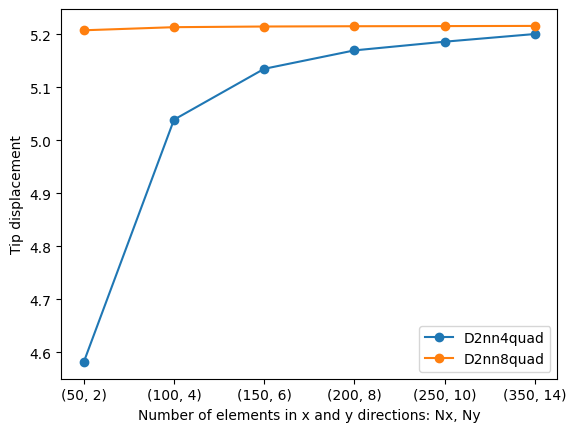

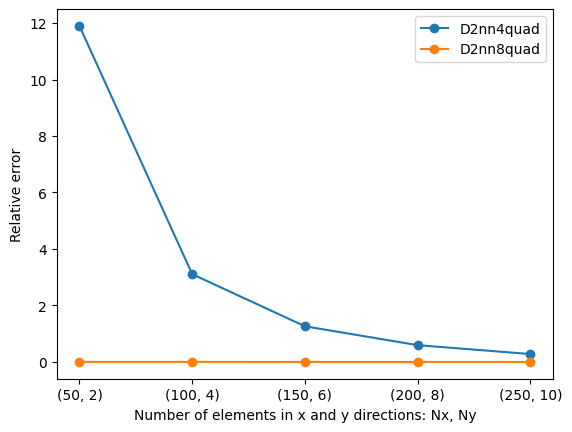

In [ ]:
%matplotlib inline
x_tick_lst = ["(50, 2)", "(100, 4)", "(150, 6)", "(200, 8)", "(250, 10)", "(350, 14)"]
x = list( range( len( x_tick_lst ) ) )
plt.figure()
plt.plot( x, tipcenterdisp_D2nn4quad_lst, marker='o', linestyle='-' )
plt.plot( x, tipcenterdisp_D2nn8quad_lst, marker='o', linestyle='-'  )
plt.xticks( x, x_tick_lst )

plt.xlabel("Number of elements in x and y directions: Nx, Ny")
plt.ylabel("Tip displacement")
plt.legend(["D2nn4quad", "D2nn8quad"])

plt.figure()
plt.plot( x[:-1], rel_error_D2nn4quad_lst, marker='o', linestyle='-' )
plt.plot( x[:-1], rel_error_D2nn8quad_lst, marker='o', linestyle='-'  )
plt.xticks( x[:-1], x_tick_lst[:-1] )

plt.xlabel("Number of elements in x and y directions: Nx, Ny")
plt.ylabel("Absolute relative error")
plt.legend(["D2nn4quad", "D2nn8quad"])

plt.show()


**Conclusion**:
It appears that either mesh D2nn4quad, (Nx, Ny) = (350, 14) or D2nn8quad, (Nx, Ny) = (250, 10) can be sufficient options the this mesh refinement problem.